In [1]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

import jax

key = jax.random.PRNGKey(420)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)

plt.style.use('ggplot')


In [2]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def minus_div(f,arg_num=0):
    jac=jacfwd(f,argnums=arg_num)
    def divergence(x,y):
        return -1*jnp.trace(jac(x,y))
    return divergence

def k_laplacian(f,arg_num=0):
    return minus_div(grad(f,argnums=arg_num),arg_num=arg_num)

def laplacian(f,arg_num=0):
    hess= hessian(f,argnums=arg_num)
    def lap(x):
        return -1*jnp.trace(hess(x))
    return lap

k= get_gaussianRBF(0.1)
k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(None,0)), in_axes=(0,None))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(None,0)), in_axes=(0,None))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(None,0)), in_axes=(0,None))

def true_solution_single(x):
    return jnp.sin(2*np.pi*x[0])*jnp.sin(2*np.pi*x[1])

true_solution=jit(jax.vmap(true_solution_single,in_axes=0))
rhs_func = jit(jax.vmap(laplacian(true_solution_single)))

In [3]:
m_interp=50
xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
meshX,meshY=np.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([meshX.flatten(),meshY.flatten()]).T

interp_solution=(true_solution(interpolation_points)).reshape(m_interp,m_interp)
interp_rhs=(rhs_func(interpolation_points)).reshape(m_interp,m_interp)

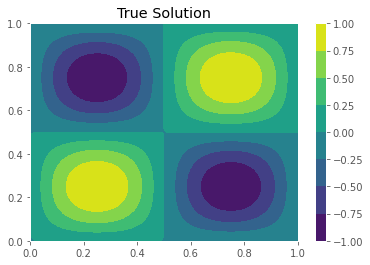

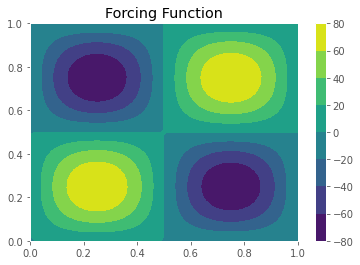

In [4]:
plt.title("True Solution")
plt.contourf(meshX,meshY,interp_solution)
plt.colorbar()
plt.show()
plt.title("Forcing Function")
plt.contourf(meshX,meshY,interp_rhs)
plt.colorbar()
plt.show()

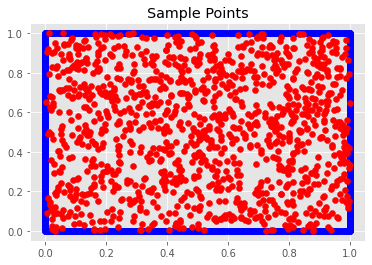

In [5]:
num_interior=1200

num_per_boundary=300
num_boundary=4*num_per_boundary


interior_points = jax.random.uniform(key,shape=(num_interior,2),minval=0,maxval=1)

boundary_point_samples=np.linspace(0,1,num_per_boundary)
boundary_points = np.hstack([
    np.vstack((np.zeros(num_per_boundary),boundary_point_samples)),
    np.vstack((np.ones(num_per_boundary),boundary_point_samples)),
    np.vstack((boundary_point_samples,np.ones(num_per_boundary))),
    np.vstack((boundary_point_samples,np.zeros(num_per_boundary)))
]).T

all_points = jnp.vstack([interior_points,boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:,0],boundary_points[:,1],c='blue')
plt.scatter(interior_points[:,0],interior_points[:,1],c='red')
plt.show()

In [6]:
K1 = vec_k_laplap(interior_points,interior_points)
K2 = vec_k_lapx(interior_points,boundary_points)
K3 = K2.T
K4 = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [K1,K2],
        [K3,K4]
    ]
)

interior_rhs = rhs_func(interior_points)
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

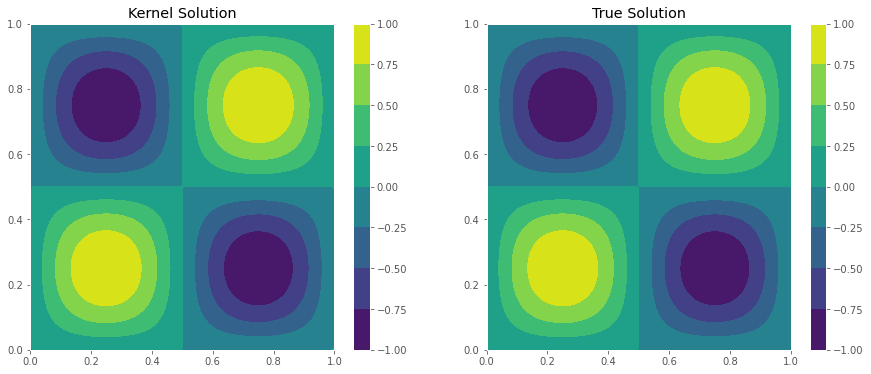

max norm residual and refined residual
3.564454801985306e-05
1.9750259802941983e-05
max norm error and refined error
1.4339411791297607e-07
5.1954884838778526e-08


In [7]:
nugget=1e-10
Kmat=K_full+nugget*jnp.diag(jnp.diag(K_full))
coef_sol=jax.scipy.linalg.solve(Kmat,rhs_total,assume_a='pos')
residual = rhs_total - K_full@coef_sol
coef_sol_refined=coef_sol+jax.scipy.linalg.solve(Kmat,residual,assume_a='pos')

residual_refined = rhs_total - K_full@coef_sol_refined

eval_K=vec_k(all_points,interior_points).T
sol_vals = eval_K@coef_sol


num_grid_points=100
xgrid=jnp.linspace(0,1,num_grid_points)
ygrid=jnp.linspace(0,1,num_grid_points)

XX,YY=jnp.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([XX.flatten(),YY.flatten()]).T

interp_k = jnp.block(
    [
        [vec_k_lapx(interpolation_points,interior_points),vec_k(interpolation_points,boundary_points)]
    ]
)

interp_solution=(interp_k@coef_sol).reshape(num_grid_points,num_grid_points)
interp_solution_refined=(interp_k@coef_sol_refined).reshape(num_grid_points,num_grid_points)

interp_rhs = rhs_func(interpolation_points).reshape(num_grid_points,num_grid_points)
interp_true_sol = true_solution(interpolation_points).reshape(num_grid_points,num_grid_points)
error = interp_solution-interp_true_sol
error_refined = interp_solution_refined-interp_true_sol



fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
plot1=ax1.contourf(xgrid,ygrid,interp_solution)
ax1.set_title("Kernel Solution")
plt.colorbar(plot1,ax=ax1)
plot2=ax2.contourf(xgrid,ygrid,interp_true_sol)
plt.colorbar(plot2,ax=ax2)

ax2.set_title("True Solution")
plt.show()

print("max norm residual and refined residual")
print(jnp.max(jnp.abs(residual)))
print(jnp.max(jnp.abs(residual_refined)))
print("max norm error and refined error")
print(jnp.max(jnp.abs(error)))
print(jnp.max(jnp.abs(error_refined)))

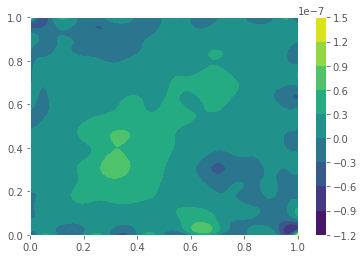

In [8]:
plt.contourf(XX,YY,error)
plt.colorbar()

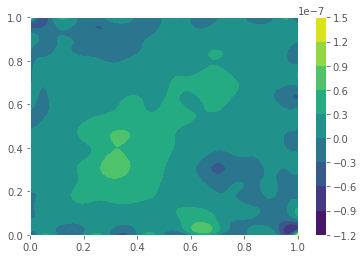

In [9]:
plt.contourf(XX,YY,error)
plt.colorbar()

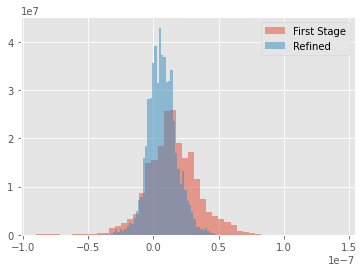

In [10]:
plt.hist(error.flatten(),50,alpha=0.5,density=True,label="First Stage")
plt.hist(error_refined.flatten(),50,alpha=0.5,density=True,label='Refined')
plt.legend()
plt.show()

## Solve and learn poisson all at once

In [11]:
k= get_gaussianRBF(0.1)
k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(None,0)), in_axes=(0,None))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(None,0)), in_axes=(0,None))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(None,0)), in_axes=(0,None))


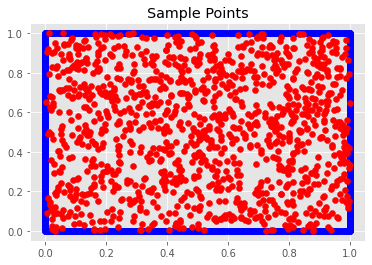

In [12]:
num_interior=1200

num_per_boundary=300
num_boundary=4*num_per_boundary


interior_points = jax.random.uniform(key,shape=(num_interior,2),minval=0,maxval=1)

boundary_point_samples=np.linspace(0,1,num_per_boundary)
boundary_points = np.hstack([
    np.vstack((np.zeros(num_per_boundary),boundary_point_samples)),
    np.vstack((np.ones(num_per_boundary),boundary_point_samples)),
    np.vstack((boundary_point_samples,np.ones(num_per_boundary))),
    np.vstack((boundary_point_samples,np.zeros(num_per_boundary)))
]).T

all_points = jnp.vstack([interior_points,boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:,0],boundary_points[:,1],c='blue')
plt.scatter(interior_points[:,0],interior_points[:,1],c='red')
plt.show()

In [20]:
jax.random.normal

<function jax._src.random.normal(key: Union[jax.Array, jax._src.prng.PRNGKeyArray], shape: Union[Sequence[int], jax.core.NamedShape] = (), dtype: Union[Any, str, numpy.dtype, jax._src.SupportsDType] = <class 'numpy.float64'>) -> jax.Array>

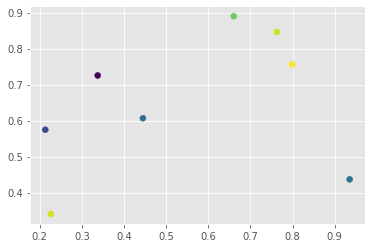

In [50]:
num_observed=8
observed_points = jax.random.uniform(key,shape=(num_observed,2),minval=0,maxval=1)
observed_values = true_solution(observed_points)#+0.05*jax.random.normal(key,[num_observed])
plt.scatter(observed_points[:,0],observed_points[:,1],c=observed_values)
plt.savefig("data_solve_learn.png")

In [51]:
Klaplap = vec_k_laplap(interior_points,interior_points)
KlapIB = vec_k_lapx(interior_points,boundary_points)
KlapBI = KlapIB.T
KBB = vec_k(boundary_points,boundary_points)

K_obs_alpha = jnp.block(
    [
        [vec_k_lapx(observed_points,interior_points),vec_k(observed_points,boundary_points)]
    ]
)


K_alpha = jnp.block(
    [
        [Klaplap,KlapIB],
        [KlapBI,KBB]
    ]
)

K_beta = jnp.block(
    [
        [vec_k(interior_points,interior_points)],
        [jnp.zeros((num_boundary,num_interior))]
    ])
KII=vec_k(interior_points,interior_points)

n_alpha=len(all_points)
n_beta =num_interior

lambda_reg_alpha=1e-8
lambda_reg_beta=1e-8

nugget_alpha=1e-4
nugget_beta=1e-4

pde_constraint_weight = 1
point_match_weight = 1

def pde_loss(alpha,beta):
    return jnp.mean((K_alpha@alpha-K_beta@beta)**2)

def regression_loss(alpha,beta):
    return (jnp.mean((K_obs_alpha@alpha-observed_values)**2))

def reg_alpha(alpha,beta):
    return alpha@(K_alpha+nugget_alpha*jnp.diag(jnp.diag(K_alpha)))@alpha

def reg_beta(alpha,beta):
    return beta@(KII+nugget_beta*jnp.diag(jnp.diag(KII)))@beta

def loss(coefficients):
    alpha=coefficients[:n_alpha]
    beta =coefficients[n_alpha:n_alpha+n_beta]
    return (
        pde_constraint_weight*pde_loss(alpha,beta)+
        point_match_weight*regression_loss(alpha,beta)+
        lambda_reg_alpha*reg_alpha(alpha,beta)+
        lambda_reg_beta*reg_beta(alpha,beta)
    )



In [52]:
loss_hessian=hessian(loss)
loss_grad =grad(loss)

coefficients_init = jnp.zeros(n_alpha+n_beta)
H=loss_hessian(coefficients_init)
g=loss_grad(coefficients_init)

coefficients=-1*jnp.linalg.solve(H,g)
alpha_sol=coefficients[:n_alpha]
beta_sol =coefficients[n_alpha:n_alpha+n_beta]

In [48]:
print("PDE Mismatch MSE:",pde_loss(alpha_sol,beta_sol))
print("Regression MSE:",regression_loss(alpha_sol,beta_sol))
print("alpha RKHS norm:",reg_alpha(alpha_sol,beta_sol))
print("beta RKHS norm:",reg_beta(alpha_sol,beta_sol))
print("Overall Loss:",loss(coefficients))


num_grid_points=40
xgrid=jnp.linspace(0,1,num_grid_points)
ygrid=jnp.linspace(0,1,num_grid_points)

XX,YY=jnp.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([XX.flatten(),YY.flatten()]).T

interp_k_alpha = jnp.block(
    [
        [vec_k_lapx(interpolation_points,interior_points),vec_k(interpolation_points,boundary_points)]
    ]
)

interp_k_beta = vec_k(interpolation_points,interior_points)

interp_solution=(interp_k_alpha@alpha_sol).reshape(num_grid_points,num_grid_points)
interp_rhs=(interp_k_beta@beta_sol).reshape(num_grid_points,num_grid_points)

interp_true_sol = true_solution(interpolation_points).reshape(num_grid_points,num_grid_points)
interp_true_rhs = rhs_func(interpolation_points).reshape(num_grid_points,num_grid_points)

print(jnp.mean((interp_true_sol-interp_solution)**2))

PDE Mismatch MSE: 1.7690005580632624e-05
Regression MSE: 6.69378686273866e-07
alpha RKHS norm: 1684.2379793341854
beta RKHS norm: 6603.685911095842
Overall Loss: 0.00010123862317120677
0.2776450774814715


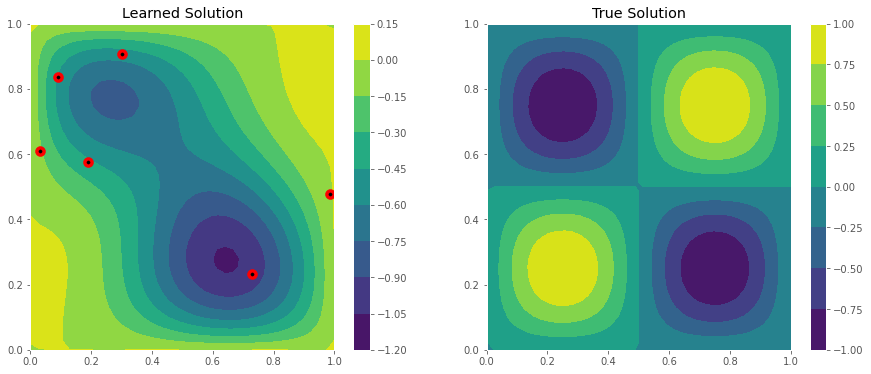

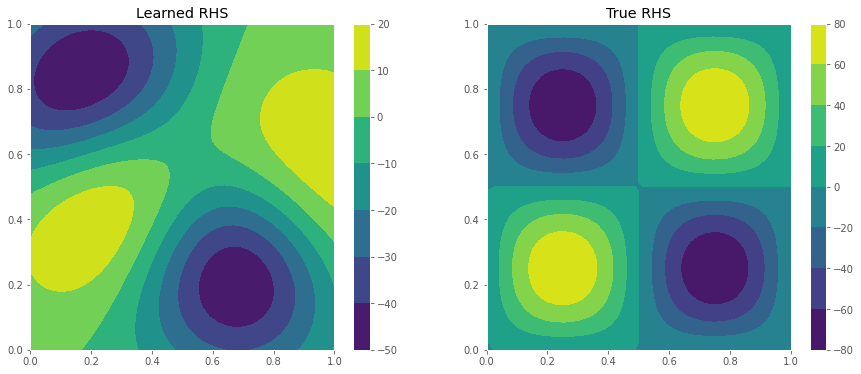

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
plot1=ax1.contourf(xgrid,ygrid,interp_solution)
ax1.scatter(observed_points[:,0],observed_points[:,1],c='red',s=100)
ax1.scatter(observed_points[:,0],observed_points[:,1],c='black',s=10)

ax1.set_title("Learned Solution")
plt.colorbar(plot1,ax=ax1)
plot2=ax2.contourf(xgrid,ygrid,interp_true_sol)
plt.colorbar(plot2,ax=ax2)

ax2.set_title("True Solution")
plt.savefig('u_learn_poisson.png')

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
plot1=ax1.contourf(xgrid,ygrid,interp_rhs)
ax1.set_title("Learned RHS")
plt.colorbar(plot1,ax=ax1)
plot2=ax2.contourf(xgrid,ygrid,interp_true_rhs)
plt.colorbar(plot2,ax=ax2)

ax2.set_title("True RHS")
plt.savefig('rhs_learn_poisson.png')
plt.show()